# Introduction

This notebook is used to compare the performance of the various models tested. Note that unless otherwise stated, the comparison was done using the NO2 pollutant data.

# Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from air_quality.model import Model
import air_quality.utils as aqutils

In [2]:
# Disable logging of INFO level to prevent pytorch lightning messages.
import logging
logging.disable(20)

# Comparisons

## Model type

In this test we compare the performance of several model types, each set to a configuration identical or close to the Darts default configuration.

In [3]:
def get_models_from_dir(dir_path):
    model_dirs = os.listdir(dir_path)
    models = {}
    for model_dir in model_dirs:
        model = Model.load_model(f"{dir_path}/{model_dir}")
        models[model_dir] = model
    return models

In [4]:
group_dir_path = 'Models comparisons/New Model type'

In [5]:
comparison_models = get_models_from_dir(group_dir_path)

In [6]:
def get_model_choices(comparison_models):
    choices = {}
    for label, model in comparison_models.items():
        covariate_features = {
            'past_covariates' : model.get_past_covariates_features(),
            'future_covariates' : model.get_future_covariates_features()
        }
        choices[label] = {
            **model.get_model_choices(),
            **covariate_features
        }
            
    return pd.DataFrame(choices)

In [7]:
with pd.option_context('display.max_colwidth', None):
    display(get_model_choices(comparison_models))

,Exponential Smoothing,TCN,Linear Regression,Block RNN LSTM,TFT,NBEATS,Transformer
target_series_names,[NO2],[NO2],[NO2],[NO2],[NO2],[NO2],[NO2]
train_val_data_start,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00
train_val_data_end,2021-09-11 06:00:00,2021-09-11 06:00:00,2021-09-11 06:00:00,2021-09-11 06:00:00,2021-09-11 06:00:00,2021-09-11 06:00:00,2021-09-11 06:00:00
early_stopper_patience,5,5,5,5,5,5,5
forecast_horizon,24,24,24,24,24,24,24
max_epochs,25,25,25,25,25,25,25
past_covariates,None,"[dwpt, pres, rhum, temp, wdir, wspd, hour, day_of_week, month]","[dwpt, pres, rhum, temp, wdir, wspd, hour, day_of_week, month]","[dwpt, pres, rhum, temp, wdir, wspd, hour, day_of_week, month]","[dwpt, pres, rhum, temp, wdir, wspd, hour, day_of_week, month]","[dwpt, pres, rhum, temp, wdir, wspd, hour, day_of_week, month]","[dwpt, pres, rhum, temp, wdir, wspd, hour, day_of_week, month]"
future_covariates,None,None,"[DewPointC, cloudcover, humidity, pressure, tempC, winddirDegree, windspeedKmph, hour, day_of_week, month]",None,"[DewPointC, cloudcover, humidity, pressure, tempC, winddirDegree, windspeedKmph, hour, day_of_week, month]",None,None


In [8]:
def get_model_args(comparison_models):
    summaries = []
    for label, model in comparison_models.items():
        summary_series = pd.Series(model.model_args)
        summary_series.name = label
        summaries.append(pd.DataFrame(summary_series))
    return summaries

In [9]:
for df in get_model_args(comparison_models):
    display(df)

,Exponential Smoothing
Class,ExponentialSmoothing


,TCN
Class,TCNModel
log_tensorboard,False
save_checkpoints,True
input_chunk_length,32
batch_size,32
nr_epochs_val_period,1
dropout,0.1
likelihood,Deterministic
learning_rate,0.001
early_stopper,MeanSquaredError


,Linear Regression
Class,LinearRegressionModel
lags,32
lags_past_covariates,32
lags_future_covariates,True


,Block RNN LSTM
Class,BlockRNNModel
log_tensorboard,False
save_checkpoints,True
input_chunk_length,32
batch_size,32
nr_epochs_val_period,1
likelihood,Deterministic
learning_rate,0.001
early_stopper,MeanSquaredError
model,LSTM


,TFT
Class,TFTModel
log_tensorboard,False
save_checkpoints,True
input_chunk_length,32
batch_size,32
nr_epochs_val_period,1
dropout,0.1
likelihood,Deterministic
learning_rate,0.001
early_stopper,MeanSquaredError


,NBEATS
Class,NBEATSModel
log_tensorboard,False
save_checkpoints,True
input_chunk_length,32
batch_size,32
nr_epochs_val_period,1
dropout,0.1
likelihood,Deterministic
learning_rate,0.001
early_stopper,MeanSquaredError


,Transformer
Class,TransformerModel
log_tensorboard,False
save_checkpoints,True
input_chunk_length,32
batch_size,32
nr_epochs_val_period,1
d_model,128
nhead,32
num_encoder_layers,4
num_decoder_layers,4


### Validation period forecast

We get the forecasts for a prediction over the whole validation period. This in itself is not particularly useful, but we can then shorten the results to whatever length forecast we want, begining at the start of the validation period.

I chose to produce 1 day, 3 day and 5 day forecasts.

In [10]:
def get_validation_period_forecasts(comparison_models):
    output = {}
    for label, model in comparison_models.items():
        output[label] = model.get_validation_period_forecast(
            model.get_best_darts_model()
        )
    return output

In [11]:
%%capture
forecasts_by_model = get_validation_period_forecasts(comparison_models)

We can get the metrics for the forecasts - again for the forecast of the whole validation period not particularly useful but we will use the function on the shorter forecasts.

In [12]:
def get_comparison_metrics(
    forecasts_by_model,
    comparison_models,
    predict_series = '',
    output_type = 'both'
):
    output = {}
    for label, model_forecasts in forecasts_by_model.items():
        output[label] = comparison_models[label].get_metrics(
            model_forecasts, predict_series = predict_series, output_type = output_type
        )
    return output

In [13]:
metrics = get_comparison_metrics(
    forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [14]:
def display_metrics(metrics):
    df = pd.DataFrame(metrics).transpose(copy = True).sort_values(by = 'MAE')
    display(df.style.format("{:.2f}"))

In [15]:
display_metrics(metrics)

,MAPE,MAE
NBEATS,61.19,8.84
Block RNN LSTM,64.00,9.19
Transformer,53.74,9.23
TFT,63.16,9.50
TCN,98.09,11.33
Linear Regression,84.50,11.42
Exponential Smoothing,71.56,11.85


Now we set up to be able to do shorter forecasts.

In [16]:
def get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = None,
    length = 1
):
    
    output = {}
    
    for label, model in comparison_models.items():
        
        forecasts = forecasts_by_model[label]
        
        start = 0 if model_starts is None else model_starts[label]
        
        # If we have trained on more than one series then we need to
        # select the right prediction series.
        if isinstance(forecasts, list):
            sliced_forecasts = []
            for forecast in forecasts:
                sliced_forecasts.append(forecast[start:(start + length)])
        else:
            sliced_forecasts = forecasts[start:(start + length)]
        
        output[label] = sliced_forecasts
        
    return output
        

In [17]:
# Set all starts to be the beginning of the validation series otherwise linear regression starts a bit earlier.
model_starts = {}
for label, model in comparison_models.items():
    val_series = model.val_series[0] if isinstance(model.val_series, list) else model.val_series
    target_series = model.target_series[0] if isinstance(model.target_series, list) else model.target_series
    hours_gap = (val_series.start_time() - target_series.end_time()).total_seconds() / 3600
    model_starts[label] = int(hours_gap)

## 1 day forecast

In [18]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 1 * 24
)

In [19]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [20]:
display_metrics(metrics)

,MAPE,MAE
Linear Regression,14.84,4.29
Transformer,18.39,5.75
TCN,20.94,5.76
TFT,26.88,5.94
Block RNN LSTM,22.92,6.17
NBEATS,28.93,8.08
Exponential Smoothing,57.47,12.46


## 3 day forecast

In [21]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 3 * 24
)

In [22]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [23]:
display_metrics(metrics)

,MAPE,MAE
TFT,28.06,4.11
Block RNN LSTM,34.22,4.51
Transformer,39.50,5.28
Linear Regression,53.34,5.55
NBEATS,71.14,7.02
TCN,99.52,9.26
Exponential Smoothing,86.34,9.70


## 5 day forecast

In [24]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 5 * 24
)

In [25]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [26]:
display_metrics(metrics)

,MAPE,MAE
TFT,29.45,3.93
Block RNN LSTM,40.13,5.07
Transformer,44.26,5.15
Linear Regression,61.42,5.53
NBEATS,78.55,6.51
Exponential Smoothing,96.43,9.30
TCN,141.39,11.23


We also define a function to plot the forecast results...

In [27]:
def plot_validation_forecasts(
    comparison_models,
    forecasts_by_model,
    predict_series = '',
    forecast_length = None
):
    for label, model in comparison_models.items():
        forecasts = forecasts_by_model[label]
        
        # If we have trained on more than one series then we need to
        # select the right prediction series.
        if isinstance(forecasts, list):
            pred_ts_sequence_index = model.forecast_pollutants.index(
                predict_series
            )
            pred_series = forecasts[pred_ts_sequence_index]
        else:
            pred_series = forecasts
        
        if forecast_length is not None:
            pred_series = pred_series.slice(
                pred_series.start_time(),
                pred_series.time_index[forecast_length]
            )
        
        plot_title = label
        if predict_series:
            plot_title += f" ({predict_series})"
        
        model.plot_forecasts(
            pred_series,
            predict_series = predict_series,
            title = plot_title
        )

...and in this case we use it to display the 5 day forecast results for each model

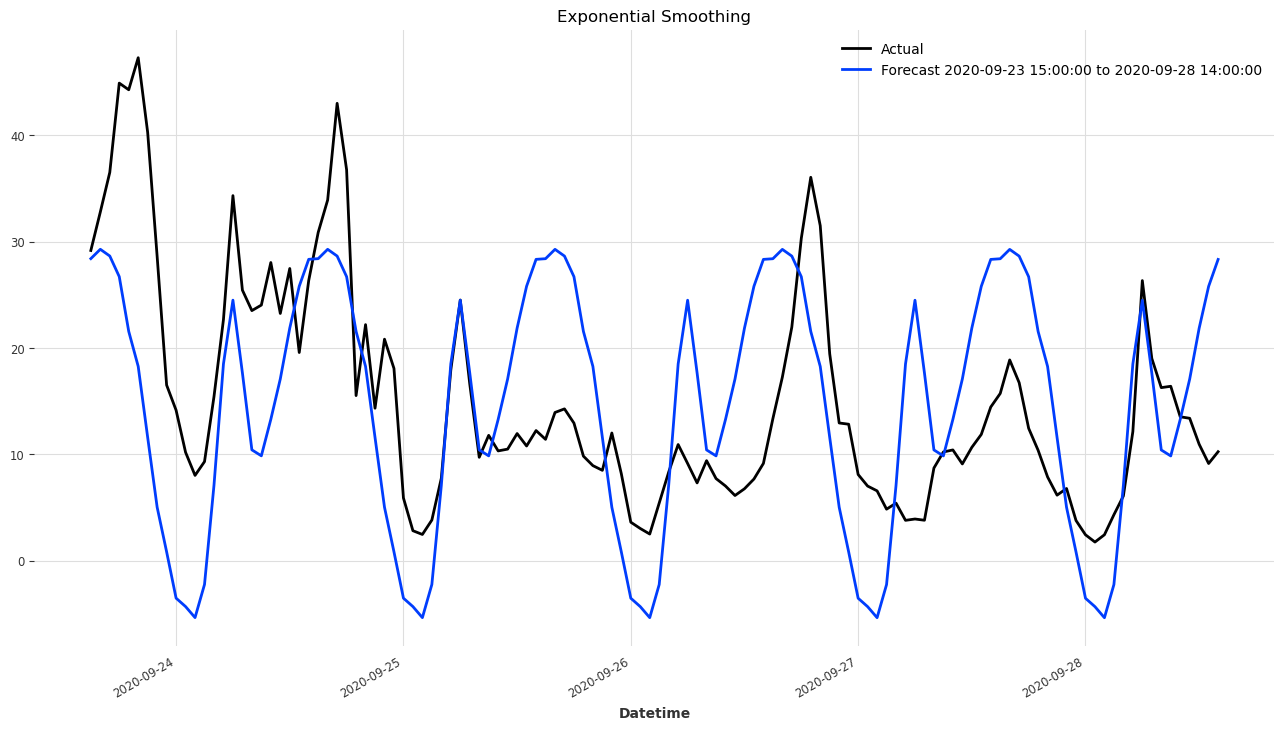

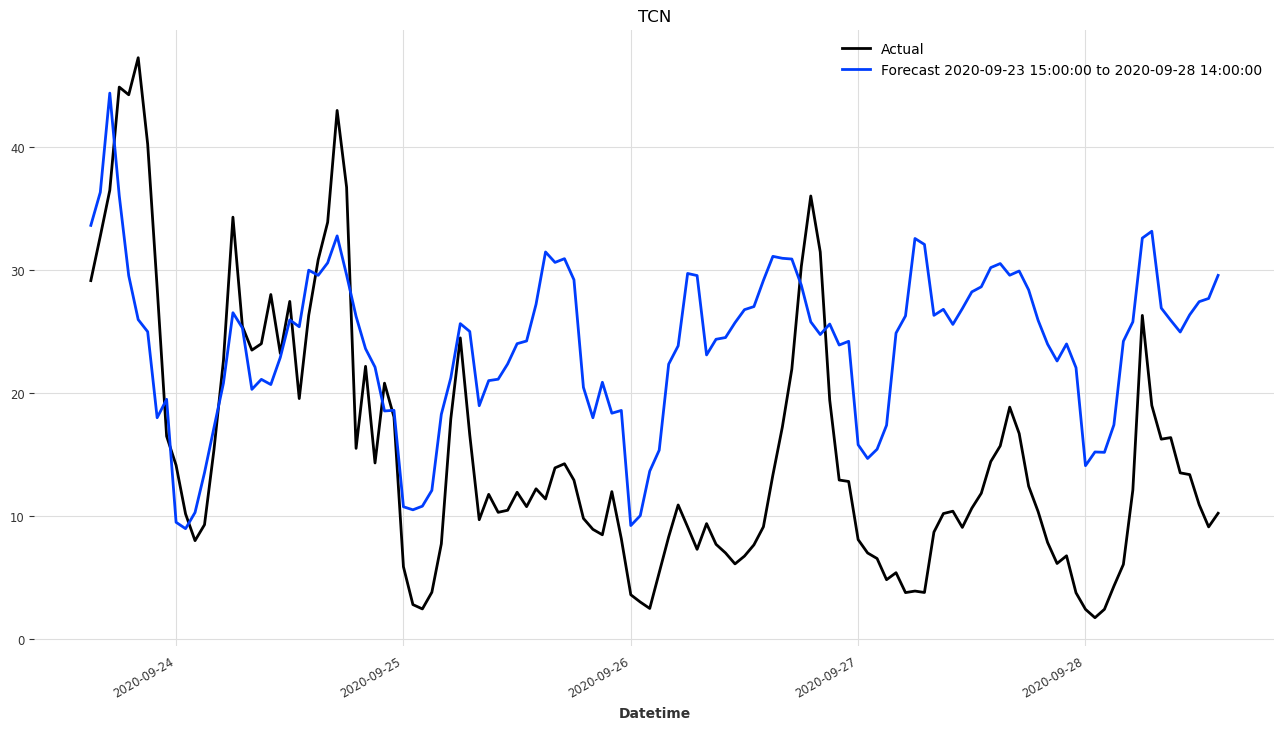

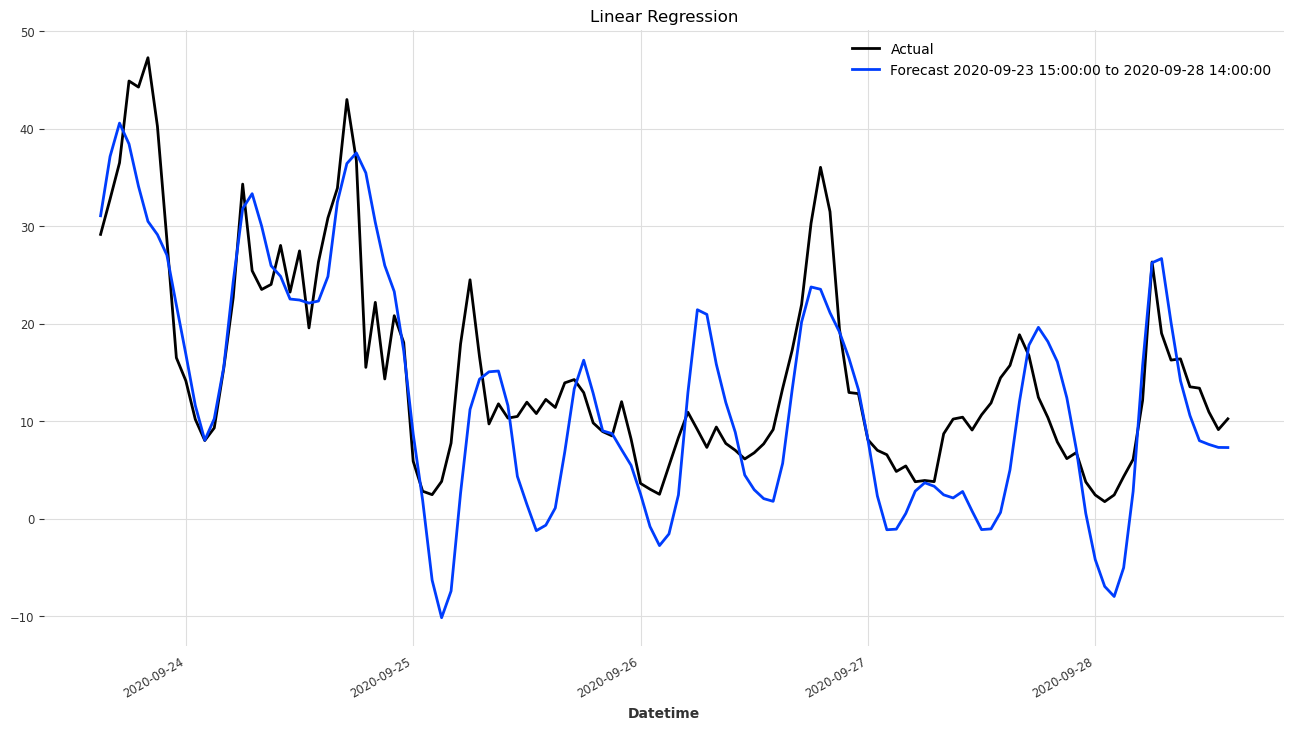

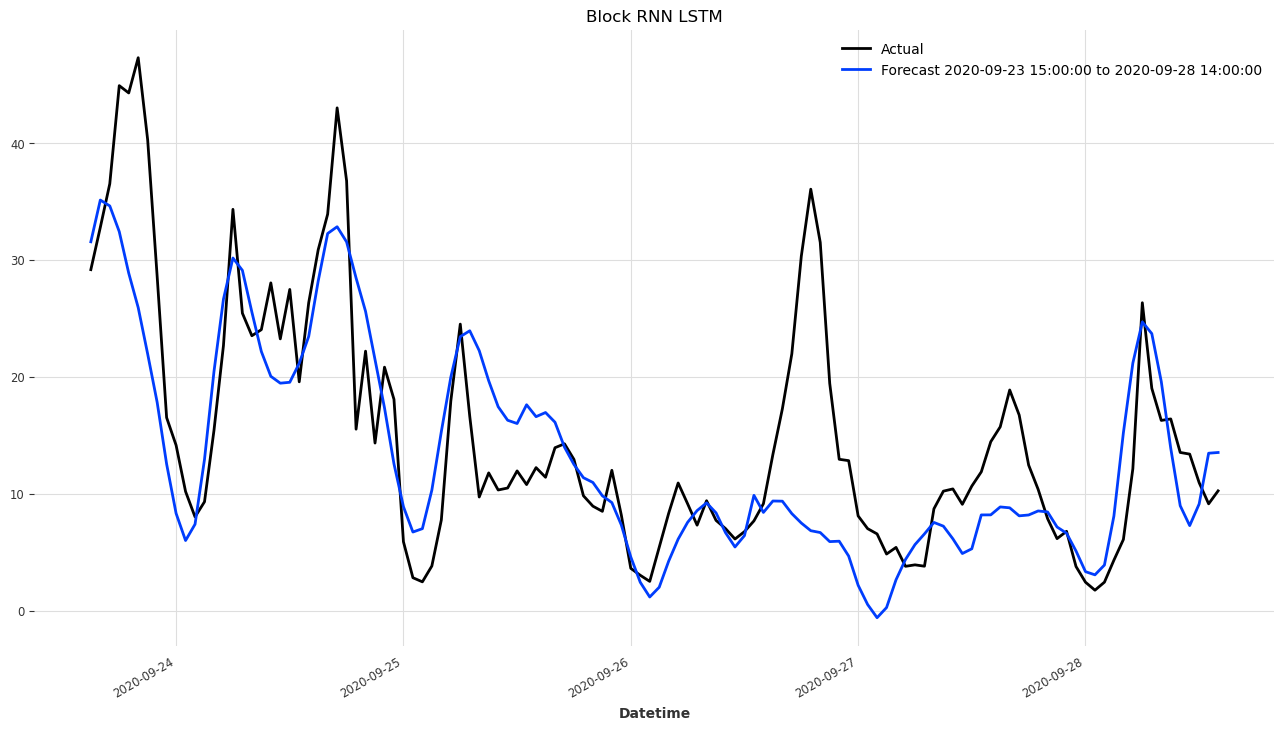

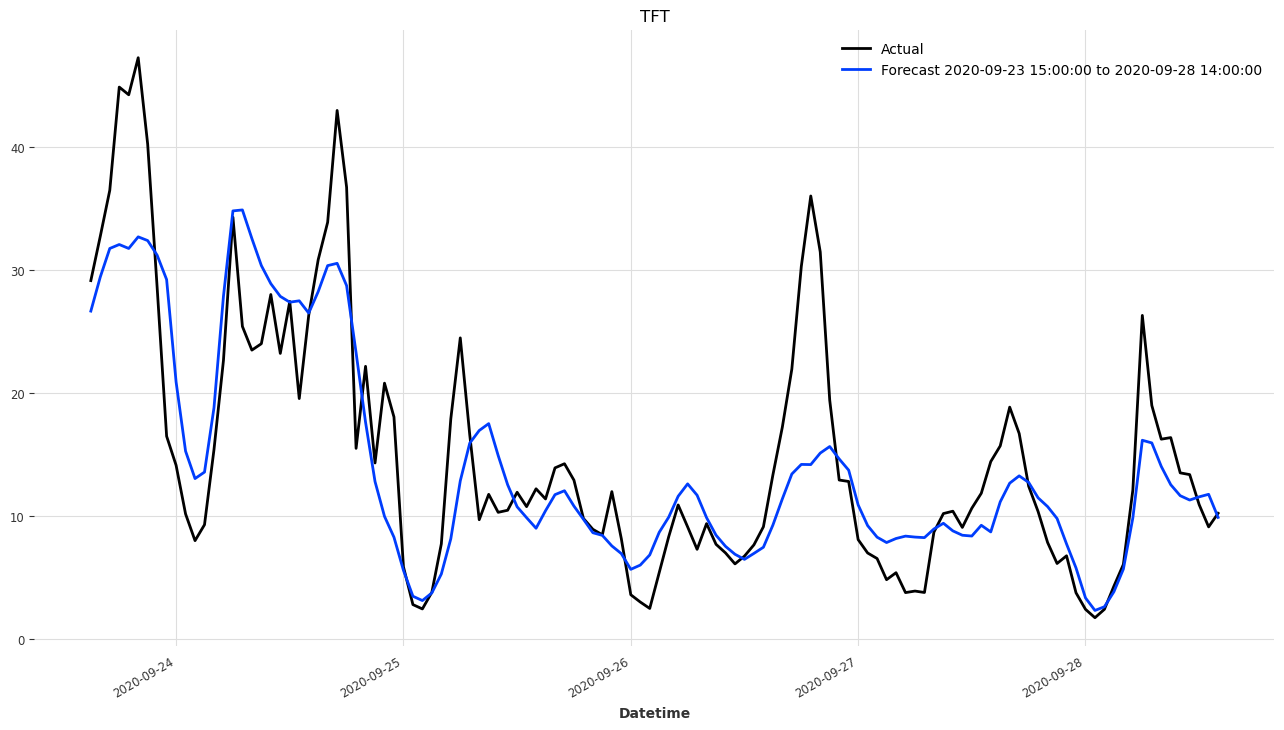

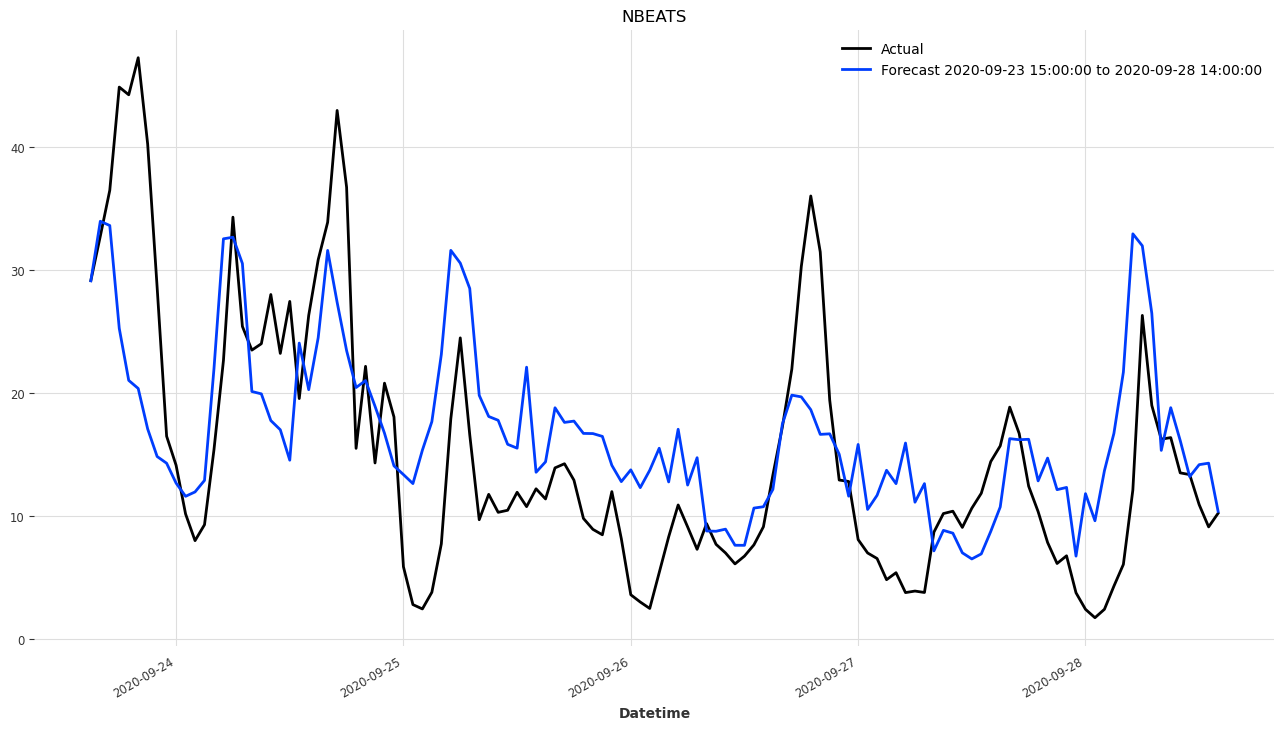

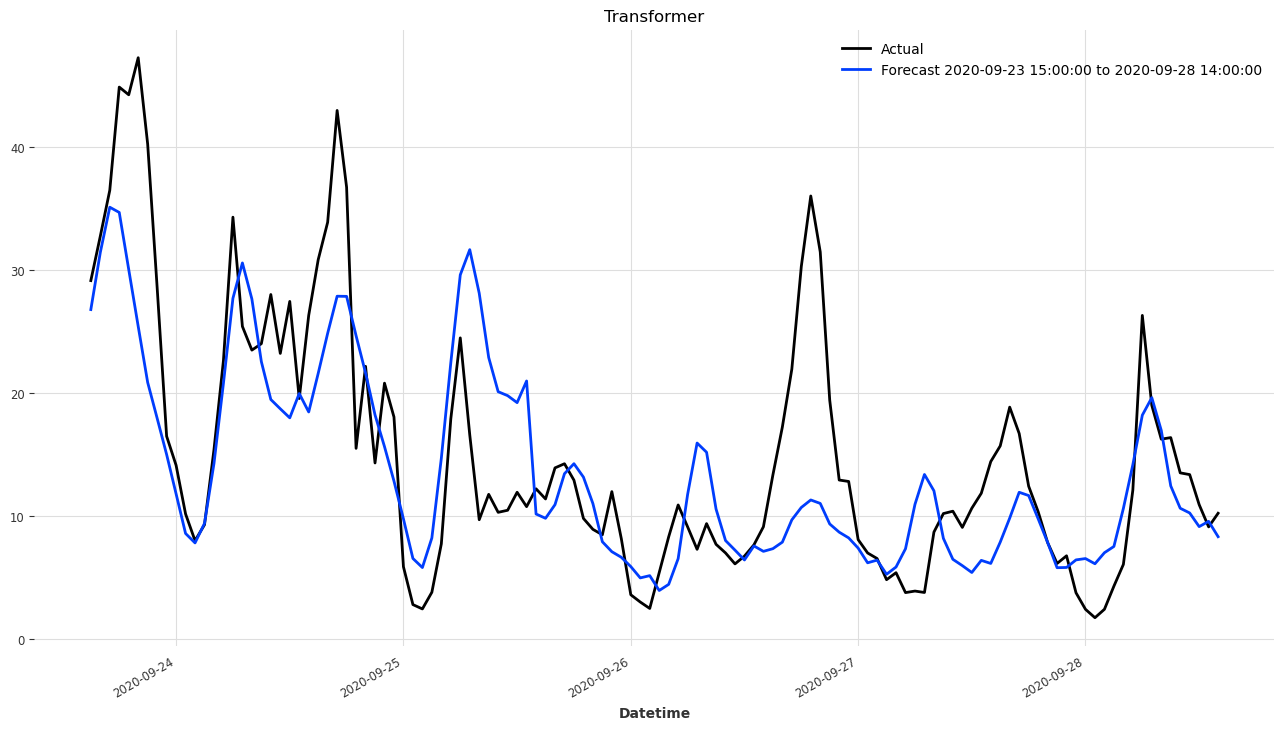

In [28]:
plot_validation_forecasts(
    comparison_models,
    sliced_forecasts_by_model,
)

# Covariates impact

This comparison looks at the impact of including or excluding past covariates, and which covariates to include (time or data). The clear winner is to include past covariates and use both time and data.

In [29]:
group_dir_path = 'Models comparisons/TFT features'
comparison_models = get_models_from_dir(group_dir_path)

In [30]:
%%capture
forecasts_by_model = get_validation_period_forecasts(comparison_models)

In [31]:
with pd.option_context('display.max_colwidth', None):
    display(get_model_choices(comparison_models))

,Data Future only,Data,Time,Time Future only,Time and data
target_series_names,[NO2],[NO2],[NO2],[NO2],[NO2]
train_val_data_start,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00
train_val_data_end,2021-09-11 06:00:00,2021-09-11 06:00:00,2021-09-11 06:00:00,2021-09-11 06:00:00,2021-09-11 06:00:00
early_stopper_patience,5,5,5,5,5
forecast_horizon,24,24,24,24,24
max_epochs,25,25,25,25,25
past_covariates,None,"[dwpt, pres, rhum, temp, wdir, wspd]","[hour, day_of_week, month]",None,"[dwpt, pres, rhum, temp, wdir, wspd, hour, day_of_week, month]"
future_covariates,"[DewPointC, cloudcover, humidity, pressure, tempC, winddirDegree, windspeedKmph]","[DewPointC, cloudcover, humidity, pressure, tempC, winddirDegree, windspeedKmph]","[hour, day_of_week, month]","[hour, day_of_week, month]","[DewPointC, cloudcover, humidity, pressure, tempC, winddirDegree, windspeedKmph, hour, day_of_week, month]"


In [32]:
metrics = get_comparison_metrics(
    forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [33]:
pd.DataFrame(metrics)

,Data Future only,Data,Time,Time Future only,Time and data
MAPE,57.925344,69.891894,70.597732,61.191130,64.852947
MAE,8.934886,10.094392,9.005246,8.383846,9.755693


In [34]:
# Set all starts to be the beginning of the validation series otherwise linear regression starts a bit earlier.
model_starts = {}
for label, model in comparison_models.items():
    val_series = model.val_series[0] if isinstance(model.val_series, list) else model.val_series
    target_series = model.target_series[0] if isinstance(model.target_series, list) else model.target_series
    hours_gap = (val_series.start_time() - target_series.end_time()).total_seconds() / 3600
    model_starts[label] = int(hours_gap)

## 1 day forecast

In [35]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 1 * 24
)

In [36]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [37]:
display_metrics(metrics)

,MAPE,MAE
Data,25.56,4.80
Time and data,23.72,4.96
Time,21.22,5.58
Time Future only,28.16,5.98
Data Future only,28.51,6.96


## 3 day forecast

In [38]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 3 * 24
)

In [39]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [40]:
display_metrics(metrics)

,MAPE,MAE
Time and data,35.44,4.07
Data,39.03,4.20
Data Future only,29.37,5.06
Time,103.67,9.93
Time Future only,121.30,11.13


## 5 day forecast

In [41]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 5 * 24
)

In [42]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [43]:
display_metrics(metrics)

,MAPE,MAE
Time and data,44.05,4.22
Data,55.10,4.73
Data Future only,38.56,4.94
Time,106.09,9.27
Time Future only,108.54,9.28


### 5 day forecast plots

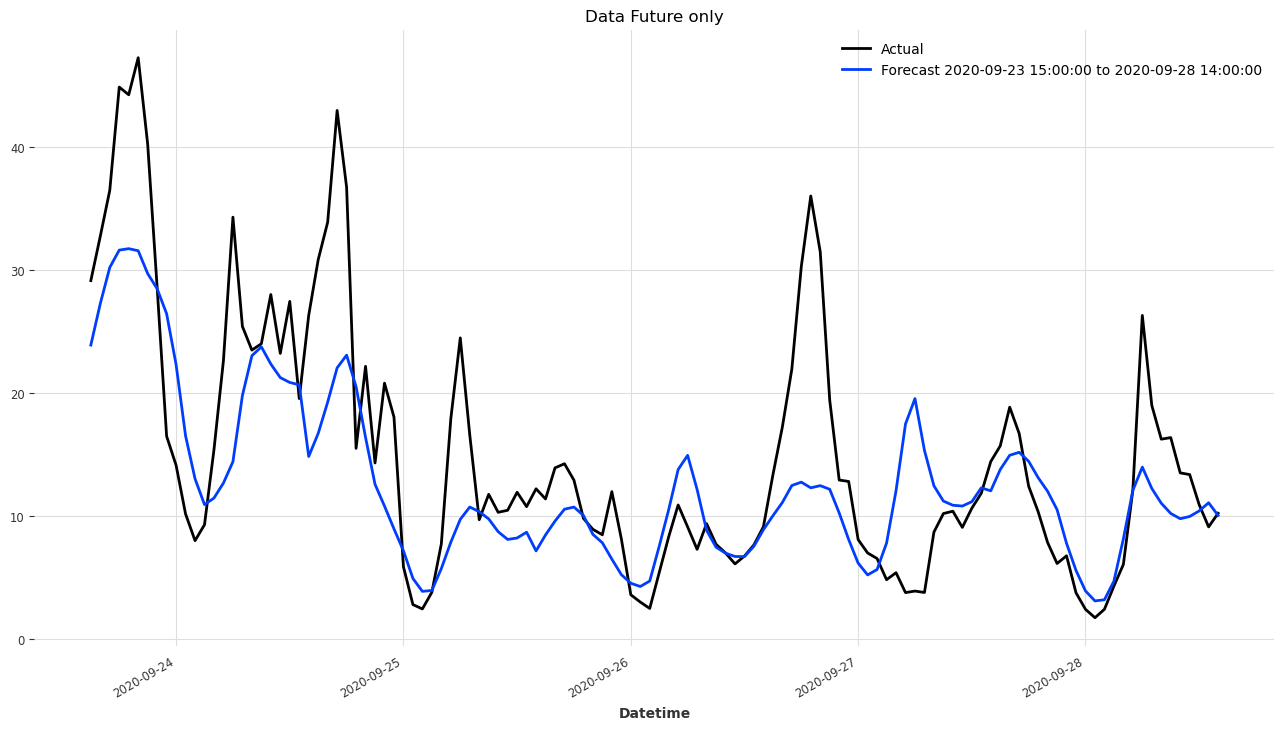

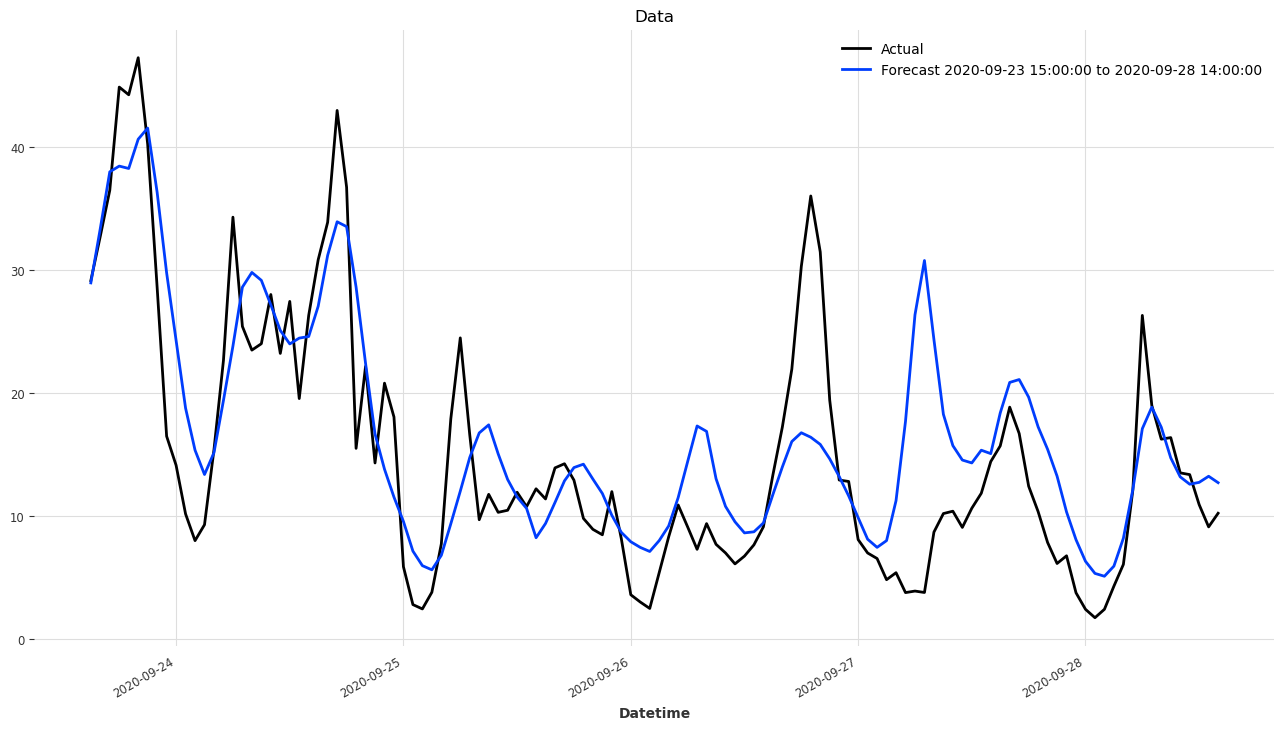

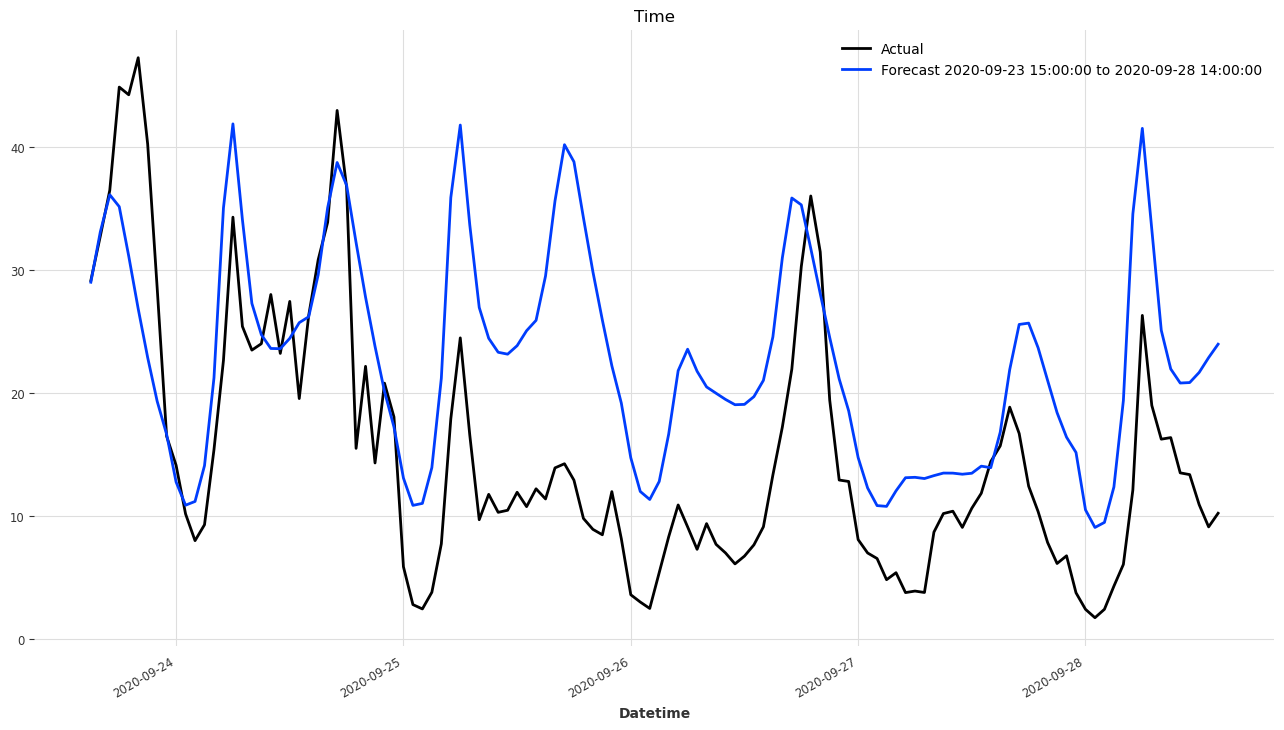

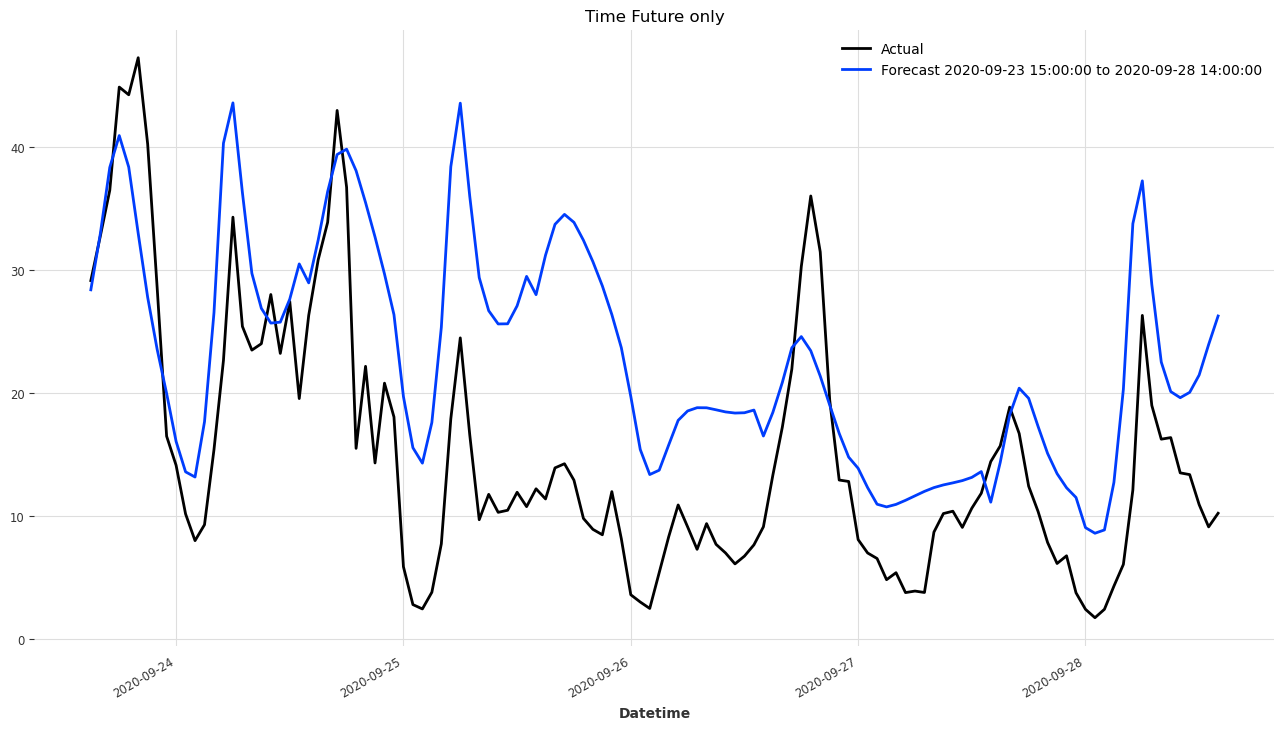

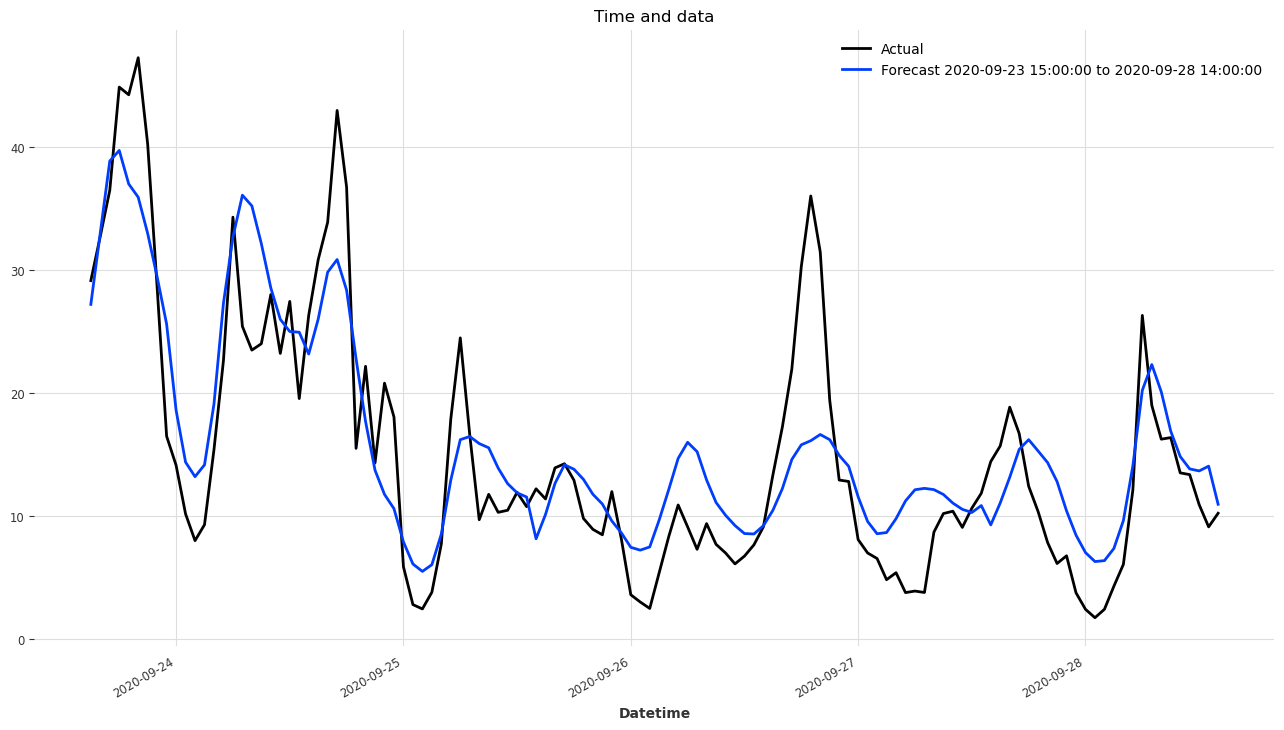

In [44]:
plot_validation_forecasts(
    comparison_models,
    sliced_forecasts_by_model,
)

# Output and input chunks

This comparison looks at using a longer input chunk length (128 vs 32) and output chunk length (120 vs 24). The longer lengths perform slightly better for 3 and 5 day forecasts, but worse for the 1 day forecast.

In [45]:
group_dir_path = 'Models comparisons/Input output lengths'
comparison_models = get_models_from_dir(group_dir_path)

In [46]:
%%capture
forecasts_by_model = get_validation_period_forecasts(comparison_models)

In [47]:
def get_model_args(comparison_models):
    summaries = []
    for label, model in comparison_models.items():
        summary_series = pd.Series(model.model_args)
        summary_series.name = label
        summaries.append(pd.DataFrame(summary_series))
    return summaries

In [48]:
for df in get_model_args(comparison_models):
    display(df)

,1 day
Class,TFTModel
log_tensorboard,False
save_checkpoints,True
input_chunk_length,32
batch_size,32
nr_epochs_val_period,1
dropout,0.1
likelihood,Deterministic
learning_rate,0.001
early_stopper,MeanSquaredError


,5 day
Class,TFTModel
log_tensorboard,False
save_checkpoints,True
input_chunk_length,128
batch_size,32
nr_epochs_val_period,1
dropout,0.1
likelihood,Deterministic
learning_rate,0.001
early_stopper,MeanSquaredError


In [49]:
metrics = get_comparison_metrics(
    forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [50]:
pd.DataFrame(metrics)

,1 day,5 day
MAPE,64.852947,56.991887
MAE,9.755693,8.414178


In [51]:
# Set all starts to be the beginning of the validation series otherwise linear regression starts a bit earlier.
model_starts = {}
for label, model in comparison_models.items():
    val_series = model.val_series[0] if isinstance(model.val_series, list) else model.val_series
    target_series = model.target_series[0] if isinstance(model.target_series, list) else model.target_series
    hours_gap = (val_series.start_time() - target_series.end_time()).total_seconds() / 3600
    model_starts[label] = int(hours_gap)

## 1 day forecast

In [52]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 1 * 24
)

In [53]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [54]:
display_metrics(metrics)

,MAPE,MAE
1 day,23.72,4.96
5 day,17.01,5.15


## 3 day forecast

In [55]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 3 * 24
)

In [56]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [57]:
display_metrics(metrics)

,MAPE,MAE
5 day,33.34,4.02
1 day,35.44,4.07


## 5 day forecast

In [58]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 5 * 24
)

In [59]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [60]:
display_metrics(metrics)

,MAPE,MAE
5 day,38.40,3.98
1 day,44.05,4.22


### 5 day forecast plots

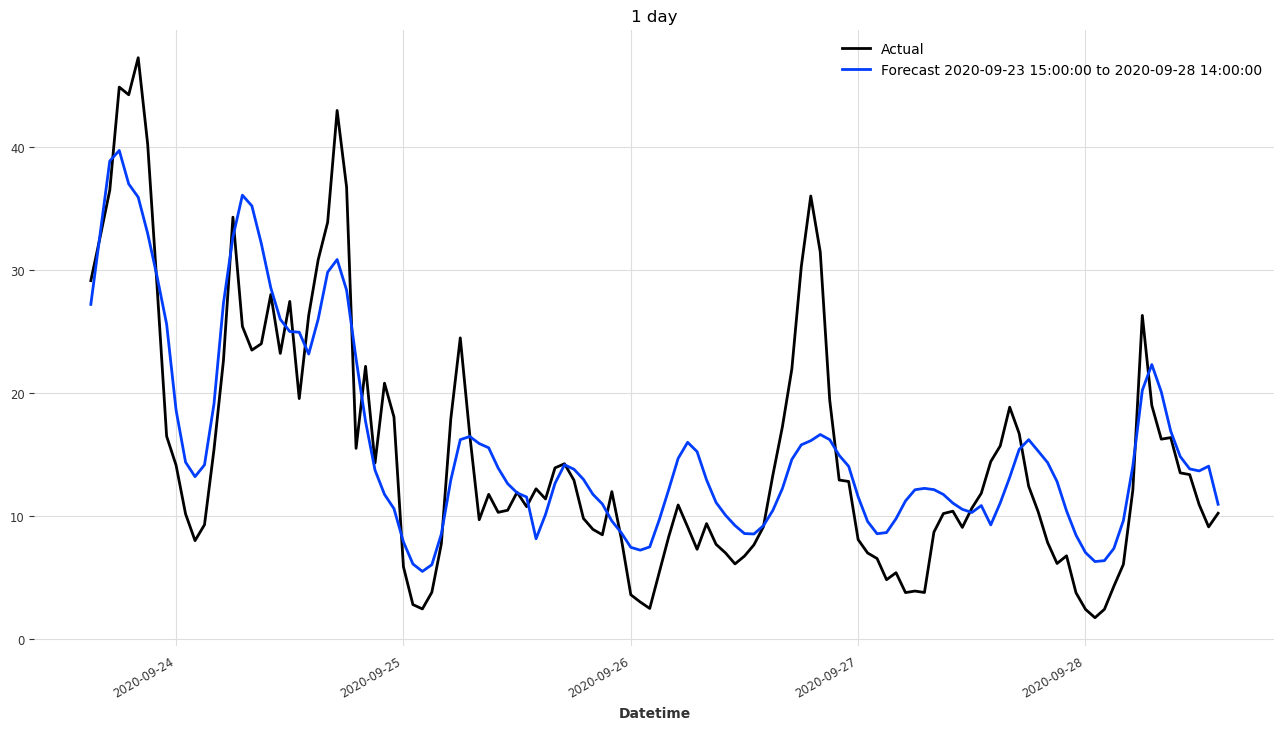

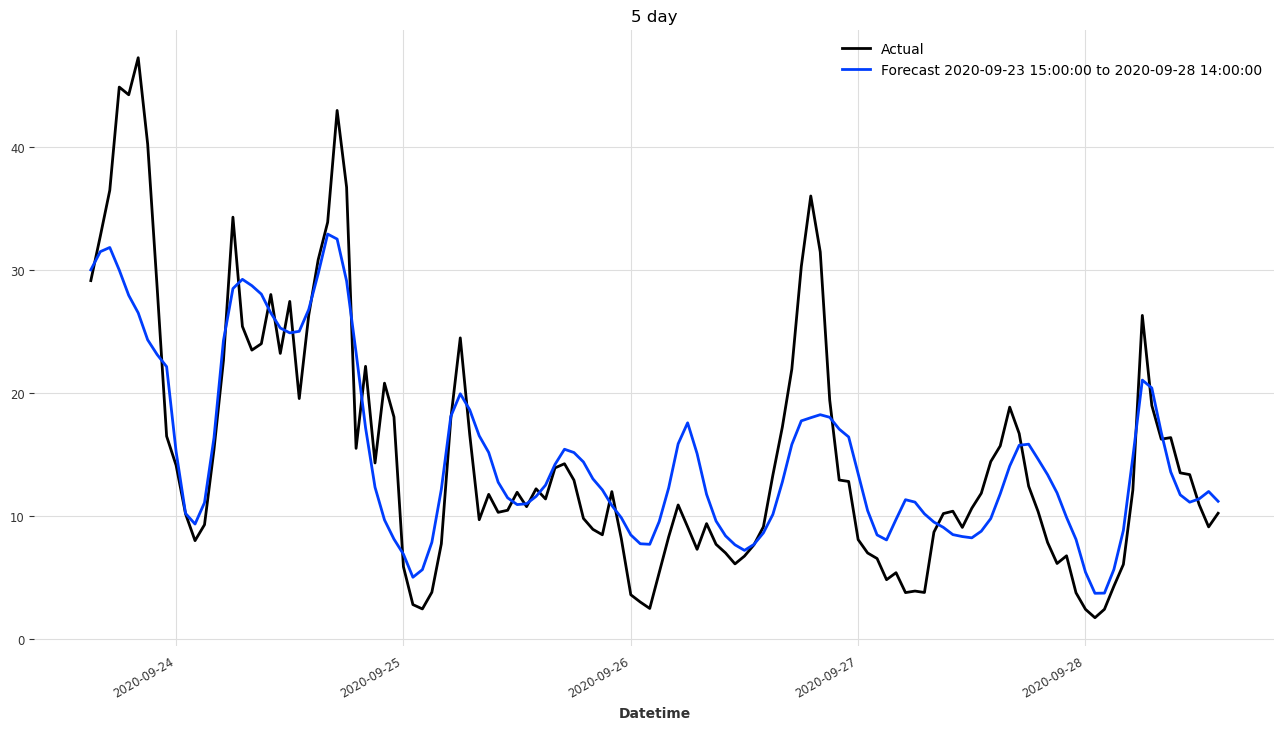

In [61]:
plot_validation_forecasts(
    comparison_models,
    sliced_forecasts_by_model,
)

# Early stopping

This comparison looks at which early stopper is better when using probabilistic training. `val_loss` is the label for the default metric used, while `mse_loss` is the custom early stopper using mean square error. The results show that the custom mean square error metric performed best on a 1 day forecast while the default metric performed better for the 3 and 5 day forecast.

In [62]:
early_stopper_model_path = 'Models comparisons/Early stopping metric/NO2'

In [63]:
comparison_models = {
    'val_loss' : Model.load_model(early_stopper_model_path),
    'mse_loss' : Model.load_model(early_stopper_model_path)
}

In [64]:
forecasts_by_model = {
    'val_loss' : comparison_models['val_loss'].get_validation_period_forecast(
        comparison_models['val_loss'].get_best_darts_model(val_loss_monitor = True)
    ),
    'mse_loss' : comparison_models['mse_loss'].get_validation_period_forecast(
        comparison_models['mse_loss'].get_best_darts_model()
    ),
}

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [65]:
# Set all starts to be the beginning of the validation series otherwise linear regression starts a bit earlier.
model_starts = {}
for label, model in comparison_models.items():
    val_series = model.val_series[0] if isinstance(model.val_series, list) else model.val_series
    target_series = model.target_series[0] if isinstance(model.target_series, list) else model.target_series
    hours_gap = (val_series.start_time() - target_series.end_time()).total_seconds() / 3600
    model_starts[label] = int(hours_gap)

## 1 day forecast

In [66]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 1 * 24
)

In [67]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [68]:
display_metrics(metrics)

,MAPE,MAE
mse_loss,17.22,4.63
val_loss,20.04,4.74


## 3 day forecast

In [69]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 3 * 24
)

In [70]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [71]:
display_metrics(metrics)

,MAPE,MAE
val_loss,25.68,3.91
mse_loss,32.68,4.29


## 5 day forecast

In [72]:
sliced_forecasts_by_model = get_forecasts_slices(
    comparison_models,
    forecasts_by_model,
    model_starts = model_starts,
    length = 5 * 24
)

In [73]:
metrics = get_comparison_metrics(
    sliced_forecasts_by_model,
    comparison_models,
    output_type = 'aggregate'
)

In [74]:
display_metrics(metrics)

,MAPE,MAE
val_loss,30.61,3.94
mse_loss,39.90,4.30


### 5 day forecast plots

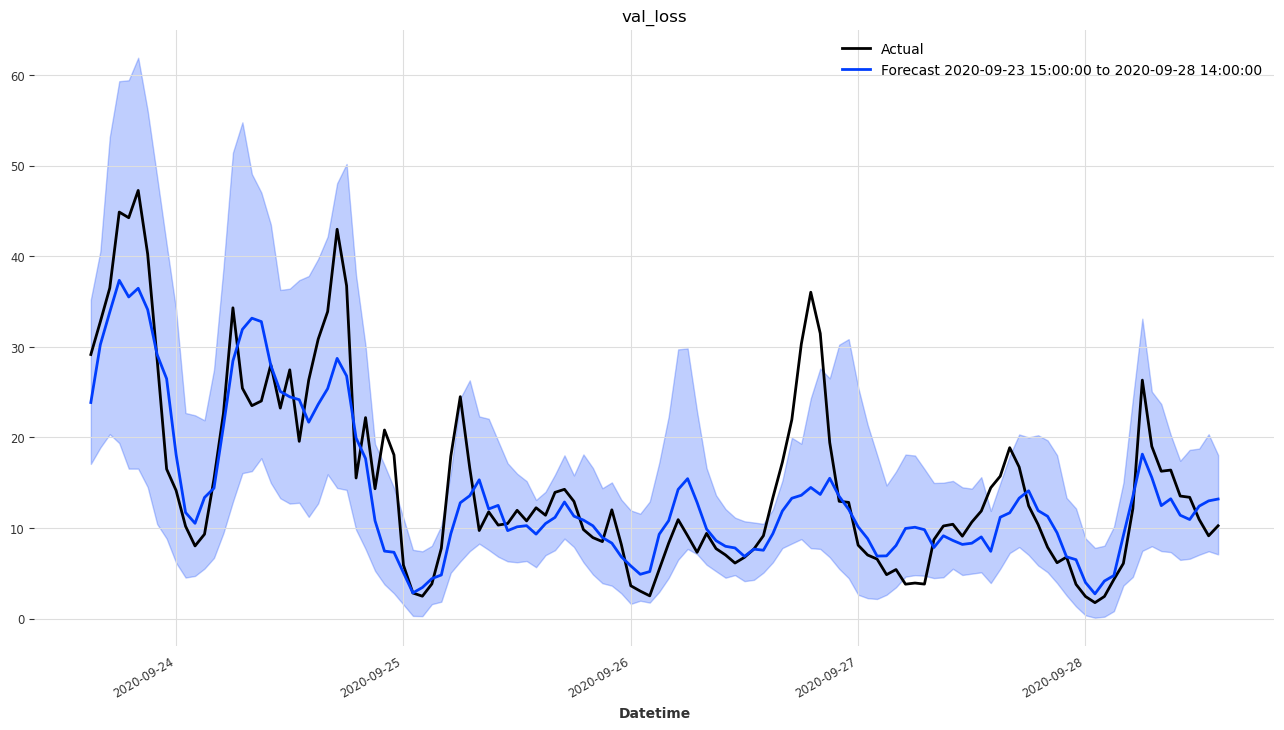

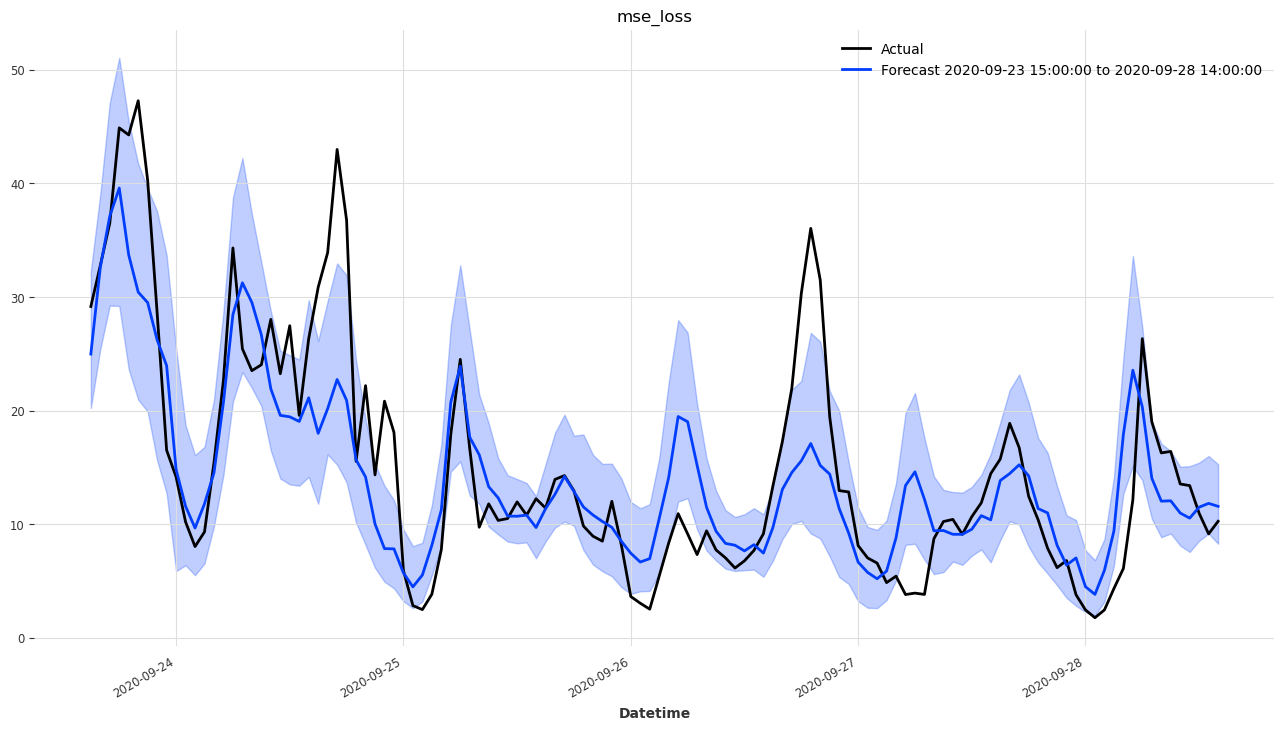

In [75]:
plot_validation_forecasts(
    comparison_models,
    sliced_forecasts_by_model,
)